In [1]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file('path/key.json')
client = bigquery.Client(credentials = credentials)

In [3]:
def query_to_bigquery(query):
    query_job = client.query(query)
    result = query_job.result()
    dataframe = result.to_dataframe()
    return dataframe

### Examine Answer Rate

In [4]:
query_answer_rate = """
   WITH t1 AS(

        SELECT
          q.id AS question_id,
          q.owner_user_id AS asker,
          MIN(q.creation_date) AS date,
          MIN(extract(month from q.creation_date)) AS month,
          MIN(extract(year from q.creation_date)) AS year,
          COUNT(a.id) AS answer_count,
          APPROX_COUNT_DISTINCT(q.owner_display_name) AS users_count,
          MIN(timestamp_diff(a.creation_date, q.creation_date, hour)) AS min_time,
          MAX(timestamp_diff(a.creation_date, q.creation_date, hour)) AS max_time,
          MAX(if(timestamp_diff(a.creation_date, q.creation_date, hour) < 25, True, False)) AS one_day,
          MAX(if(timestamp_diff(a.creation_date, q.creation_date, hour) < 169, True, False)) AS one_week,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)java($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS JavaRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)javascript($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS JavascriptRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)python($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS PythonRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)php($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS PhpRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)c\\#($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS CSharpRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)c\\+\\+($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS CplusRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)css($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS CssRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)r($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS RRate,
          AVG(IF(REGEXP_CONTAINS(q.tags, r"(^|\\|)matlab($|\\|)"),IF(q.answer_count > 0, 1, 0),NULL)) AS MatlabRate
        FROM`bigquery-public-data.stackoverflow.posts_questions` as q
        LEFT OUTER JOIN
        `bigquery-public-data.stackoverflow.posts_answers` as a
        ON q.id = a.parent_id
        GROUP BY question_id, asker
        HAVING year > 2010)

    SELECT 
        MIN(date) AS date,
        month, year,
        COUNT(question_id) AS question_count,
        AVG(min_time) AS min_avg_time,
        AVG(max_time) AS max_avg_time,
        SUM(IF(answer_count > 0, 1, 0)) / COUNT(*) AS answer_rate,
        SUM(IF(one_day, 1, 0)) / COUNT(*) AS dayanswer_rate,
        SUM(IF(one_week, 1, 0)) / COUNT(*) AS weekanswer_rate,
        AVG(JavaRate) AS Java,
        AVG(JavascriptRate) AS Javascript,
        AVG(PythonRate) AS Python,
        AVG(PhpRate) AS Php,
        AVG(CSharpRate) AS C_Sharp,
        AVG(CplusRate) AS C_plus,
        AVG(CssRate) AS Css,
        AVG(RRate) AS R,
        AVG(MatlabRate) AS Matlab
    FROM t1
    GROUP BY year, month

"""
answer_rate = query_to_bigquery(query_answer_rate)
answer_rate.head()

,date,month,year,question_count,min_avg_time,max_avg_time,answer_rate,dayanswer_rate,weekanswer_rate,Java,Javascript,Python,Php,C_Sharp,C_plus,Css,R,Matlab
0,2011-09-01 00:00:04.713000+00:00,9,2011,102951,422.174181,5885.836391,0.968432,0.836077,0.885751,0.974095,0.978539,0.980693,0.983935,0.973255,0.980238,0.987057,0.988562,0.981273
1,2017-12-01 00:00:04.557000+00:00,12,2017,146716,407.207715,1501.867813,0.830414,0.692044,0.758015,0.820425,0.845167,0.849585,0.829021,0.804898,0.833333,0.877666,0.833826,0.845691
2,2017-11-01 00:00:51.793000+00:00,11,2017,170721,396.742297,1525.971312,0.826723,0.691614,0.757540,0.817061,0.837014,0.846195,0.818858,0.801856,0.832243,0.871098,0.812625,0.828877
3,2018-06-01 00:00:05.893000+00:00,6,2018,156033,390.258700,1390.694144,0.819929,0.678715,0.747496,0.810278,0.835504,0.839834,0.806391,0.788929,0.838121,0.860173,0.807572,0.759300
4,2017-02-01 00:01:09.150000+00:00,2,2017,176677,424.984907,1917.616579,0.846007,0.714513,0.778036,0.836772,0.854494,0.868416,0.825028,0.840769,0.843061,0.898650,0.820750,0.842790


In [5]:
answer_rate.sort_values(by='date', ascending=False, inplace=True)

**Questions on StackOverFlow by year**

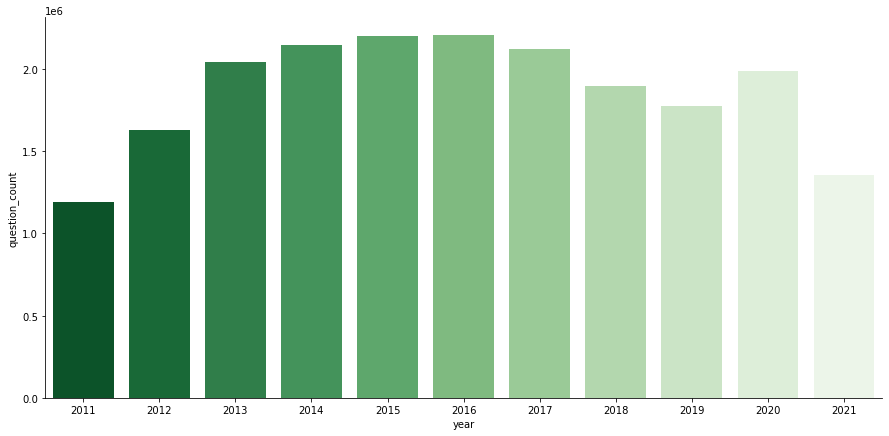

In [6]:
by_year = answer_rate.groupby('year').agg({'question_count':'sum'})
by_year = by_year.rename_axis('year').reset_index()
plt.figure(figsize=(15,7))
sns.barplot(data=by_year, x='year', y='question_count', palette='Greens_r')
sns.despine()

**Trend in Answer Rate**

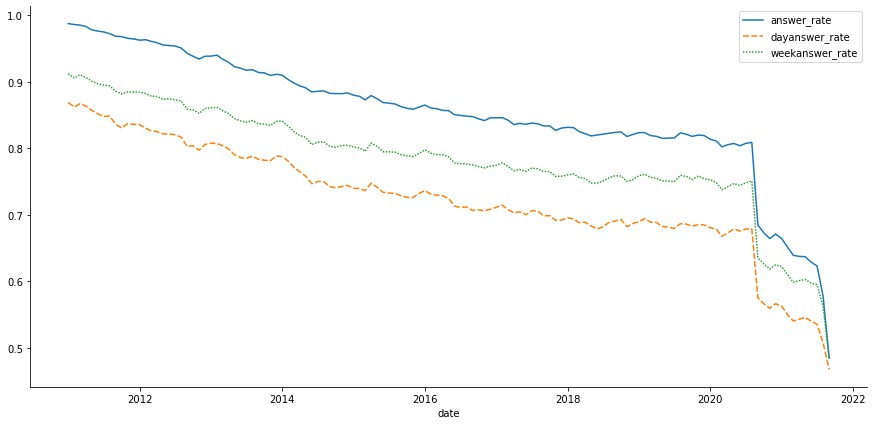

In [7]:
df = answer_rate[['date','answer_rate','dayanswer_rate','weekanswer_rate']].set_index('date')
plt.figure(figsize=(15,7))
sns.lineplot(data = df)
sns.despine()

- dayanswer_rate is the rate of questions that got the first answer within a day. The same applied to weekanswer_rate (questions that got first answers within a week).
- The answer rate overall is getting lower and lower by year. Or it could mean that older questions are more likely to get answered. But the fact that the answer rates within a day and a week also decrease strengthens the hypothesis that it's harder to got answers on StackOverflow.

**How long does it take to get the first answer**
- Although it's harder to get answers, it seems like it takes less time to get the first answer.

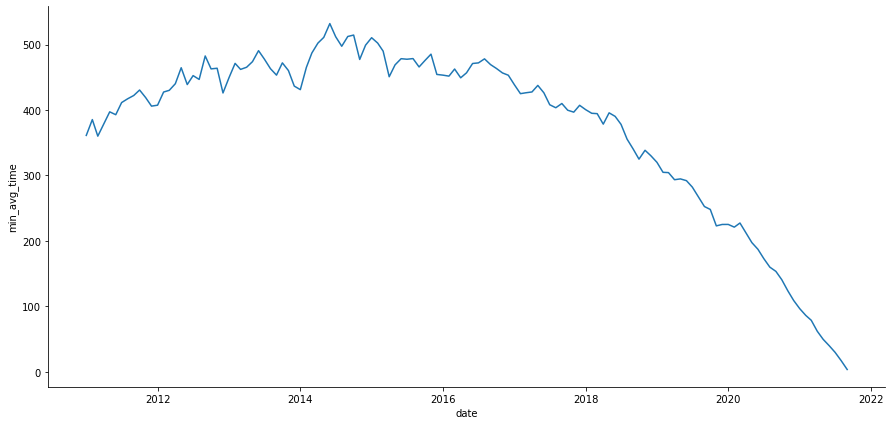

In [8]:
plt.figure(figsize=(15,7))
sns.lineplot(data = answer_rate, x='date', y='min_avg_time')
sns.despine()

**Answer rate by popular languages**

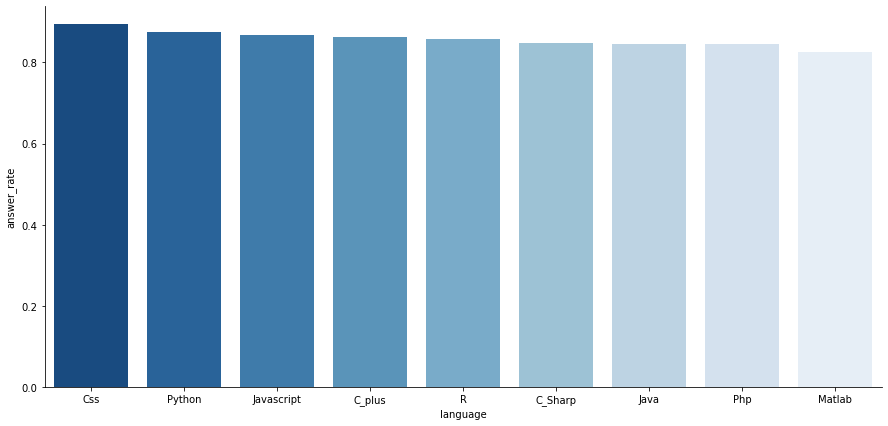

In [9]:
by_language = answer_rate.mean(axis=0)[8:].sort_values(ascending=False)
by_language = by_language.to_frame(name='answer_rate').rename_axis('language').reset_index()
plt.figure(figsize=(15,7))
sns.barplot(data=by_language, x='language', y='answer_rate', palette='Blues_r')
sns.despine()

### Top topics discussed on StackOverflow

In [10]:
query_top_tag = """
    SELECT
        tag_name, SUM(count) AS tag_count
    FROM `bigquery-public-data.stackoverflow.tags`
    GROUP BY tag_name
    ORDER BY tag_count DESC
    LIMIT 20
"""
top_tags = query_to_bigquery(query_top_tag)
top_tags.head(10)

,tag_name,tag_count
0,javascript,2265517
1,java,1796560
2,python,1788718
3,c#,1495832
4,php,1413394
5,android,1346946
6,html,1088688
7,jquery,1016910
8,c++,736134
9,css,730672


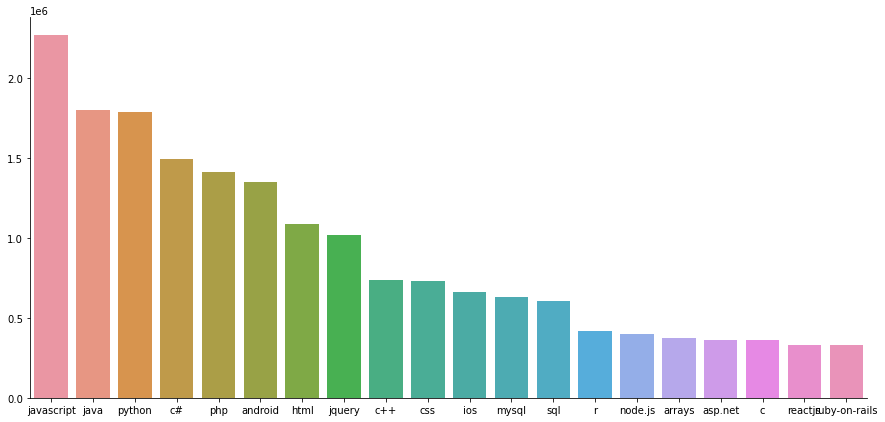

In [11]:
plt.figure(figsize=(15,7))
ax = sns.barplot(data=top_tags,x='tag_name', y='tag_count')
ax.set(xlabel=None, ylabel=None)
sns.despine()

**Get posts from top 10 users**

In [12]:
query_topuser_posts = """
        SELECT
            a.owner_user_id,
            title,
            body,
            tags
        FROM `bigquery-public-data.stackoverflow.stackoverflow_posts` a
        JOIN `vigilant-tract-338917.stackoverflow_data.top_10_user_score` b
        ON a.owner_user_id = b.owner_user_id
"""
topuser_posts = query_to_bigquery(query_topuser_posts)

In [13]:
topuser_posts_2 = topuser_posts.dropna()
topuser_posts_2.head()

,owner_user_id,title,body,tags
0,4883,Getting the GMarkers that have been added to a...,<p>Is there a way to get a list of all the GMa...,google-maps
1,4883,Where is the Core Data Starting Point Apple De...,<p>In Apple's <a href= https://developer.apple...,core-data
3,4883,How do you detect that monkey patching has occ...,<p>How do you check that monkey patching has b...,ruby|metaprogramming
4,4883,Django tag cloud plugin,<p>Is there a good Django app out there that c...,django|tag-cloud
5,4883,Prevent people from pushing a git commit with ...,<p>In git it is up to each user to specify the...,git


**What do top 10 users talk about?**

In [14]:
def keyword_analysis(df, col):
    term_nospace = [str(word).replace(' ','_') for word in df[f'{col}']]
    search_term_all = " ".join(words for words in term_nospace)
    stopwords = set(STOPWORDS)
    stopwords.update(["nan", "_and_", "_or_", "pass"])
    term = WordCloud(background_color="white", collocations=False, prefer_horizontal=1, stopwords=stopwords).generate(search_term_all)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(term, interpolation='bilinear')
    plt.axis("off")
    plt.show()

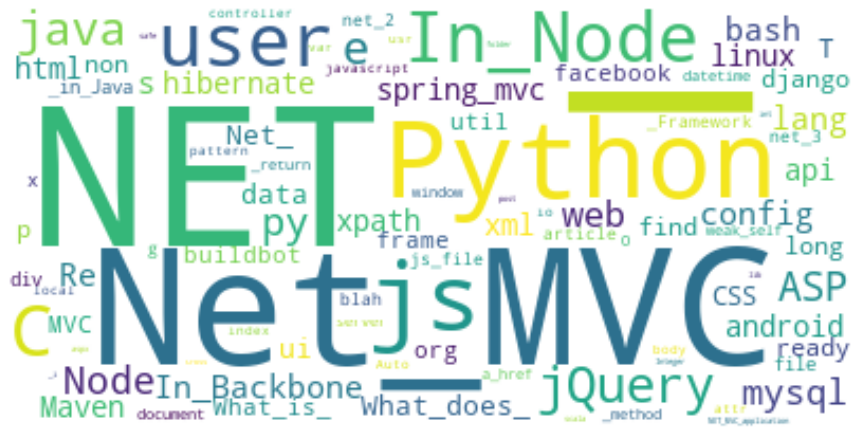

In [15]:
keyword_analysis(topuser_posts_2, 'title')

**Top 100 questions by score**

In [16]:
query_top_questions = """
    SELECT id, score, owner_user_id, title 
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    ORDER BY score DESC
    LIMIT 100
"""
top_questions = query_to_bigquery(query_top_questions)

In [17]:
top_questions.head(10)

,id,score,owner_user_id,title
0,11227809,25791,87234.0,Why is processing a sorted array faster than p...
1,927358,23089,89904.0,How do I undo the most recent local commits in...
2,2003505,18322,95592.0,How do I delete a Git branch locally and remot...
3,292357,12728,6068.0,What is the difference between 'git pull' and ...
4,231767,11409,18300.0,"What does the ""yield"" keyword do?"
5,477816,10845,12870.0,What is the correct JSON content type?
6,348170,9964,14069.0,How do I undo 'git add' before commit?
7,5767325,9761,364969.0,How can I remove a specific item from an array?
8,6591213,9633,338204.0,How do I rename a local Git branch?
9,1642028,9495,87234.0,"What is the ""-->"" operator in C/C++?"


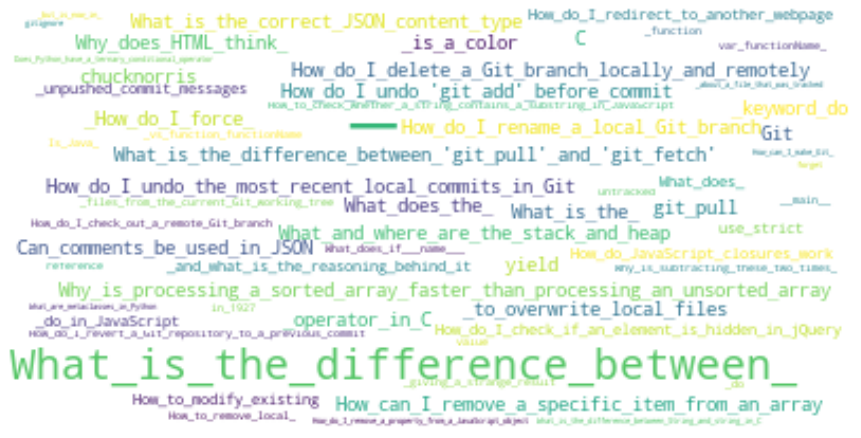

In [18]:
keyword_analysis(top_questions, 'title')